# RNN: Implementation From Scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Utils import *
from RNN import *

## Data Preprocessing

## Model Architecture

Preparing word data (one-hot inputs)...
Total words found: 140
Vocabulary size (threshold>=1): 85
Using entire text as one sequence.
Prepared 1 training sequence(s).
Starting training (One-Hot Input) for 500 epochs...
Learning rate: 0.001, Clipping: 5
Epoch 50/500, Loss: 2.9041, Time: 0.02s
Epoch 100/500, Loss: 1.1442, Time: 0.02s
Epoch 150/500, Loss: 0.4525, Time: 0.03s
Epoch 200/500, Loss: 0.2399, Time: 0.02s
Epoch 250/500, Loss: 0.1564, Time: 0.02s
Epoch 300/500, Loss: 0.1138, Time: 0.02s
Epoch 350/500, Loss: 0.0883, Time: 0.02s
Epoch 400/500, Loss: 0.0712, Time: 0.02s
Epoch 450/500, Loss: 0.0591, Time: 0.02s
Epoch 500/500, Loss: 0.0501, Time: 0.02s
Training Completed


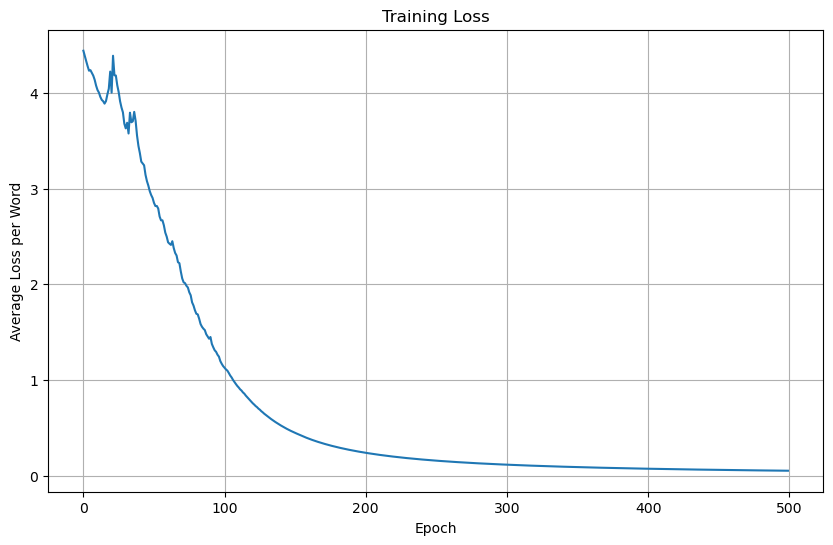


--- Sampling from the trained model (One-Hot Input) ---

Sampling (random choice) starting with 'neural':
neural neural to general exhibit are unsegmented type of is neural network of to recognize patterns similar sequences of data such as text genomes handwriting the spoken word or numerical times as data unlike feedforward neural is text feedforward their similar that memory to similar neural network cyclic an infinite impulse neural

Sampling (argmax choice) starting with 'neural':
neural neural networks or rnns are a type of artificial neural network designed to recognize patterns in sequences of data such as text genomes handwriting the spoken word or numerical times series data unlike feedforward neural networks rnns use their internal state memory to process sequences of inputs this makes them applicable


In [2]:
corpus_text = """
Recurrent Neural Networks, or RNNs, are a type of artificial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, or numerical times series data.
Unlike feedforward neural networks, RNNs use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.
The term Recurrent Neural Network is used generically to refer to two broad classes of networks with a similar general structure, where one is finite impulse and the other is infinite impulse. Both classes of networks exhibit temporal dynamic behavior. A finite impulse recurrent network is a directed acyclic graph that can be unrolled and replaced with a strictly feedforward neural network, while an infinite impulse recurrent network is a directed cyclic graph that cannot be unrolled.
"""
X_one_hot_data, Y_data, word_to_ix, ix_to_word, vocab_size = prepare_word_data_onehot(
    corpus_text,
    vocab_threshold=1
)
if not X_one_hot_data: sys.exit("Data preparation failed.")

# 2. Define Model Hyperparameters
# embedding_dim removed
hidden_dim = 100
learning_rate = 0.001
epochs = 500
clip_value = 5
print_every = 50

# 3. Instantiate Model (No embedding_size)
rnn_model = RNN(hidden_dim=hidden_dim, vocab_size=vocab_size)
rnn_model.word_to_ix = word_to_ix
rnn_model.ix_to_word = ix_to_word

# 4. Train Model (Pass one-hot X data)
loss_history = rnn_model.train(X_one_hot_data, Y_data,
                                lr=learning_rate,
                                epochs=epochs,
                                clip_value=clip_value,
                                print_every=print_every)

# 5. Plot Loss (Unchanged)
if loss_history:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.xlabel("Epoch"); plt.ylabel("Average Loss per Word")
    plt.title("Training Loss"); plt.grid(True); plt.show()

# 6. Evaluate by Sampling (Unchanged call structure)
print("\n--- Sampling from the trained model (One-Hot Input) ---")
seed_word = "neural"
h0_sample = np.zeros((hidden_dim, 1))
sample_length = 50

print(f"\nSampling (random choice) starting with '{seed_word}':")
sampled_indices_random = rnn_model.sample(seed_word, h0_sample, sample_length, sample_strategy='random')
sampled_text_random = ' '.join(ix_to_word[ix] for ix in sampled_indices_random)
print(f"{seed_word} {sampled_text_random}") # First word printed is seed + generated

print(f"\nSampling (argmax choice) starting with '{seed_word}':")
sampled_indices_argmax = rnn_model.sample(seed_word, h0_sample, sample_length, sample_strategy='argmax')
sampled_text_argmax = ' '.join(ix_to_word[ix] for ix in sampled_indices_argmax)
print(f"{seed_word} {sampled_text_argmax}") # First word printed is seed + generated